In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    interaction = 0
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words) == 1:
            interaction = 0
            i_count = 0
        elif len(words)>1 and results_follow==1: # and words[0] not in omit_list
            if len(words)==2 and words[1]=="|":
                var_name = words[0]
                interaction = 1
                i_count = 0
            else:
                if interaction==0:
                    row_names.append(words[0])
                else:
                    row_names.append(var_name+"_"+words[0])                        
                
                if words[2]=='|':
                    t00= t0+1
                    t11 = t1+1
                else:
                    t00 = t0
                    t11 = t1

                buff_v = []
                for w in words[t00:t11]: 
                    w = w.replace(",","")
                    buff_v.append(w)
                table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table 

In [3]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2023):
    time_periods_thin.append(str(y))
    
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20","t21","t22"]
period_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021'",'2022'"]
    
def rename_interaction(tab,int_subs):
    tab_chunk_1 = tab.iloc[0:7].copy()
    tab_chunk_2 = tab.iloc[7:].copy()
    tab_chunk_1.rename(index=int_subs,inplace=True)
    tab = pd.concat((tab_chunk_1,tab_chunk_2))
    return tab

## Read cases data

In [4]:
all_data = pd.read_csv('./other_data/casos_hosp_uci_def_sexo_edad_provres.csv')
all_data.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [5]:
all_data['grupo_edad'].unique()

array(['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69',
       '70-79', '80+', 'NC'], dtype=object)

In [6]:
data_10 = all_data[all_data['grupo_edad']=='0-9'].copy()
data_10 = data_10[['fecha','num_casos']]
data_20 = all_data[all_data['grupo_edad']=='10-19'].copy()
data_20 = data_20[['fecha','num_casos']]
data_30 = all_data[all_data['grupo_edad']=='30-39'].copy()
data_30 = data_30[['fecha','num_casos']]
data_10.head()

,fecha,num_casos
0,2020-01-01,0
10,2020-01-01,0
20,2020-01-01,0
30,2020-01-01,0
40,2020-01-01,0


In [7]:
data_10 = data_10.groupby('fecha').sum()
data_20 = data_20.groupby('fecha').sum()
data_30 = data_30.groupby('fecha').sum()

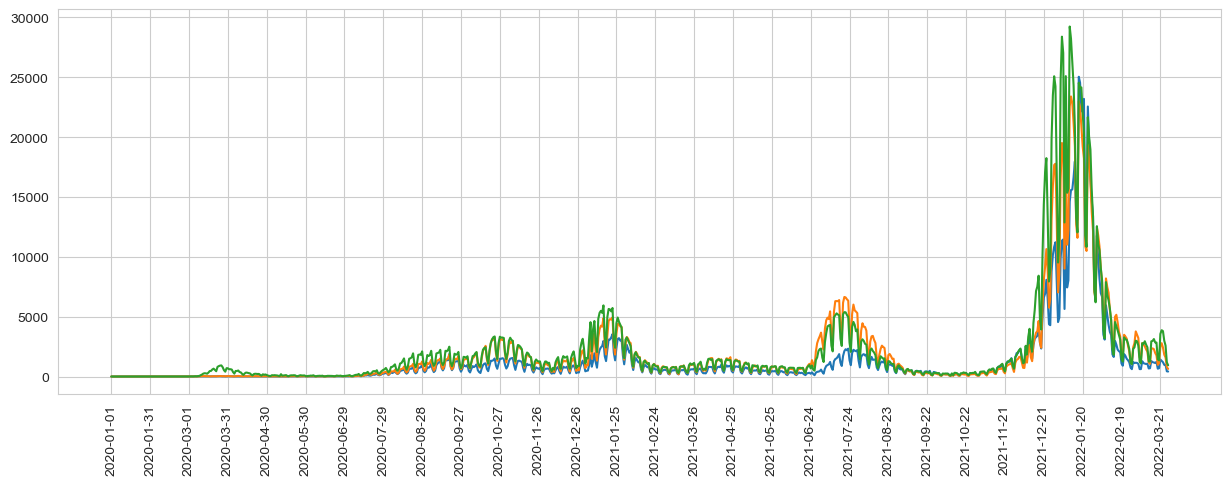

In [8]:
T = data_10['num_casos'].size
plt.figure(figsize=(15,5))
plt.plot(data_10['num_casos'].values)
plt.plot(data_20['num_casos'].values)
plt.plot(data_30['num_casos'].values)
plt.xticks(np.arange(0,T,30),data_10.index[::30], rotation=90)
plt.show()

### Comapre with ERTEs

In [9]:
path = './descriptive_stats/'

erte_mo = read_table(path+'stocks_erte_mothers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=2)
erte_wo = read_table(path+'stocks_erte_not_mothers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=2)
erte_fa = read_table(path+'stocks_erte_fathers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=2)
erte_me = read_table(path+'stocks_erte_not_fathers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=2)

In [10]:
erteh_mo = read_table(path+'stocks_erteh_mothers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=2)
erteh_fa = read_table(path+'stocks_erteh_fathers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=2)

In [11]:
erte_mo.index = erte_mo.index.map(date_dict)
erte_wo.index = erte_wo.index.map(date_dict)
erte_fa.index = erte_fa.index.map(date_dict)
erte_me.index = erte_me.index.map(date_dict)

erteh_mo.index = erteh_mo.index.map(date_dict)
erteh_fa.index = erteh_fa.index.map(date_dict)

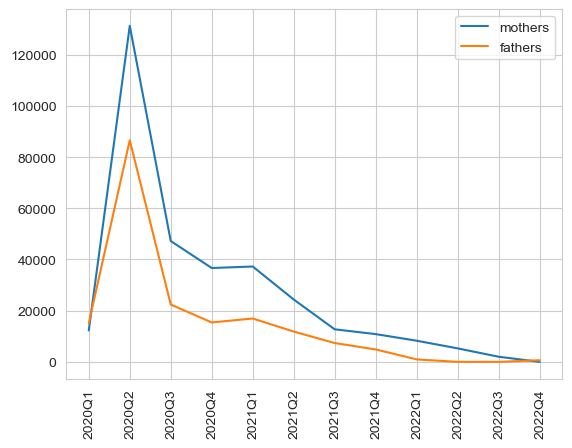

In [12]:
plt.plot(erte_mo.loc['2020Q1':,"1"],label='mothers')
plt.plot(erte_fa.loc['2020Q1':,"1"],label='fathers')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [13]:
year, months = [], []
for dt in data_10.index:
    dts =dt.split('-')
    year.append(int(dts[0]))
    months.append(int(dts[1]))
    
data_10['month'] = months
data_10['year'] = year
data_10 = data_10.set_index(['year','month'])
data_10_mm = data_10.groupby(['year','month']).sum()

data_20['month'] = months
data_20['year'] = year
data_20 = data_20.set_index(['year','month'])
data_20_mm = data_20.groupby(['year','month']).sum()

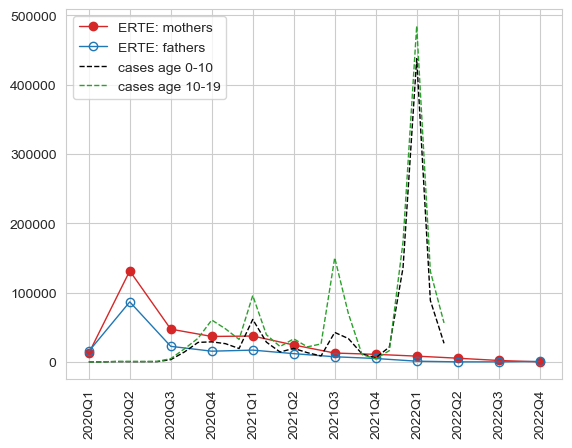

In [64]:
T = erte_mo.loc['2020Q1':,"1"].size
Tn = data_10_mm['num_casos'].size // 3
colors = sn.color_palette()
plt.plot(erte_mo.loc['2020Q1':,"1"],label='ERTE: mothers',marker='o',c=colors[3],lw=1)
plt.plot(erte_fa.loc['2020Q1':,"1"],label='ERTE: fathers',marker='o',c=colors[0],lw=1,fillstyle='none')
plt.plot(np.arange(0,Tn,1/3),data_10_mm['num_casos'].values,c='k',lw=1,ls='--',label='cases age 0-10')
plt.plot(np.arange(0,Tn,1/3),data_20_mm['num_casos'].values,c=colors[2],lw=1,ls='--',label='cases age 10-19')
plt.xticks(rotation=90)
plt.legend()
plt.savefig('./descriptive_stats/covid_vs_erte.pdf',format='pdf',bbox_inches='tight')

plt.show()

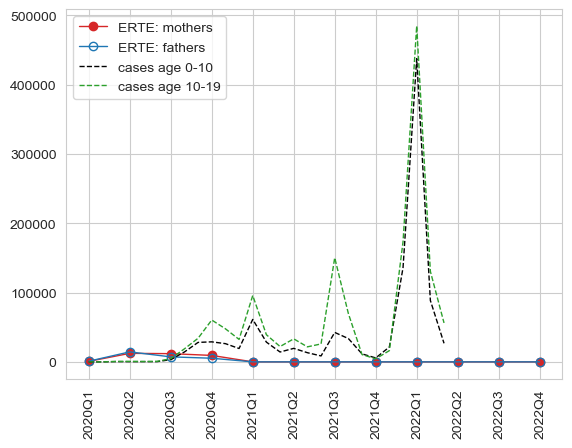

In [65]:
T = erte_mo.loc['2020Q1':,"1"].size
Tn = data_10_mm['num_casos'].size // 3
colors = sn.color_palette()
plt.plot(erteh_mo.loc['2020Q1':,"1"],label='ERTE: mothers',marker='o',c=colors[3],lw=1)
plt.plot(erteh_fa.loc['2020Q1':,"1"],label='ERTE: fathers',marker='o',c=colors[0],lw=1,fillstyle='none')
plt.plot(np.arange(0,Tn,1/3),data_10_mm['num_casos'].values,c='k',lw=1,ls='--',label='cases age 0-10')
plt.plot(np.arange(0,Tn,1/3),data_20_mm['num_casos'].values,c=colors[2],lw=1,ls='--',label='cases age 10-19')
plt.xticks(rotation=90)
plt.legend()
plt.savefig('./descriptive_stats/covid_vs_erteh.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Adding part-time

In [16]:
path = './descriptive_stats/'

pt_mo = read_table(path+'stocks_parttime_mothers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=6)
pt_mo.index = pt_mo.index.map(date_dict)

pt_nomo = read_table(path+'stocks_parttime_not_mothers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=6)
pt_nomo.index = pt_nomo.index.map(date_dict)

pt_fa = read_table(path+'stocks_parttime_fathers_3040_10_w.log',keyword='ciclo',rescale=100,ncols=6)
pt_fa.index = pt_fa.index.map(date_dict)

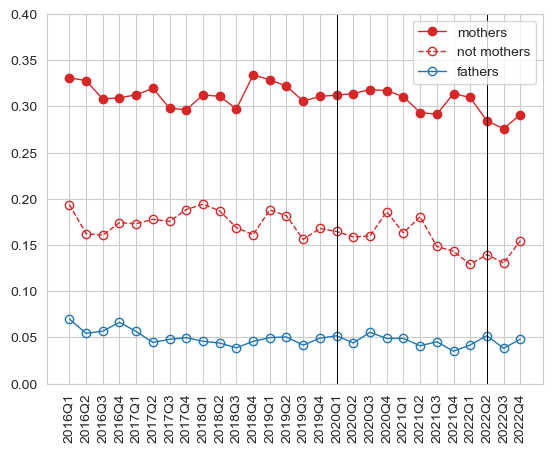

In [66]:
plt.plot(pt_mo.loc['2016Q1':,"PT"]/(pt_mo.loc['2016Q1':,"PT"]+pt_mo.loc['2016Q1':,"P"]+pt_mo.loc['2016Q1':,"T"]),
         label='mothers',marker='o',c=colors[3],lw=1)
plt.plot(pt_nomo.loc['2016Q1':,"PT"]/(pt_nomo.loc['2016Q1':,"PT"]+pt_nomo.loc['2016Q1':,"P"]+pt_nomo.loc['2016Q1':,"T"]),
         label='not mothers',marker='o',c=colors[3],lw=1,ls='--',fillstyle='none')
plt.plot(pt_fa.loc['2016Q1':,"PT"]/(pt_fa.loc['2016Q1':,"PT"]+pt_fa.loc['2016Q1':,"P"]+pt_fa.loc['2016Q1':,"T"]),
         label='fathers',marker='o',c=colors[0],lw=1,fillstyle='none')
plt.xticks(rotation=90)
plt.legend()
plt.axvline('2020Q1',c="k",lw=0.7)
plt.axvline('2022Q2',c="k",lw=0.7)
plt.ylim(0,0.4)
plt.savefig('./descriptive_stats/part_time_age3040.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [4]:
path = "./descriptive_stats/"

stocks_mo = normalise_table(read_table(path+'stocks_mothers_age3040_10_w.log',keyword='ciclo',rescale=100,ncols=5))
stocks_wo = normalise_table(read_table(path+'stocks_not_mothers_age3040_w.log',keyword='ciclo',rescale=100,ncols=5))
stocks_fa = normalise_table(read_table(path+'stocks_fathers_age3040_10_w.log',keyword='ciclo',rescale=100,ncols=5))
stocks_me = normalise_table(read_table(path+'stocks_not_fathers_age3040_w.log',keyword='ciclo',rescale=100,ncols=5))

stocks_mo.index = stocks_mo.index.map(date_dict)
stocks_wo.index = stocks_wo.index.map(date_dict)

stocks_mo.tail()

,A,I,P,T,U,Total
2021Q4,0.088785,0.199162,0.423795,0.168495,0.119763,1314741.50
2022Q1,0.095195,0.207093,0.410568,0.163427,0.123717,1285416.69
2022Q2,0.093005,0.212289,0.429944,0.149965,0.114797,1249755.99
2022Q3,0.095104,0.210698,0.456819,0.119149,0.118231,1217805.88
2022Q4,0.086772,0.210341,0.478860,0.113021,0.111006,1219860.15


In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.interpolate import interp1d # for interpolation of new data points

lowess = sm.nonparametric.lowess

In [ ]:
# x values for Linear Regression
y=hist_dict[p_age][k_age][year]['women']
# y values for both
X=ten_range[:-1]

# ------- LOWESS -------
# Generate y_hat values using lowess, try a couple values for hyperparameters
y_hat1 = lowess(y.values, X) # note, default frac=2/3
y_hat2 = lowess(y.values, X, frac=1/5)

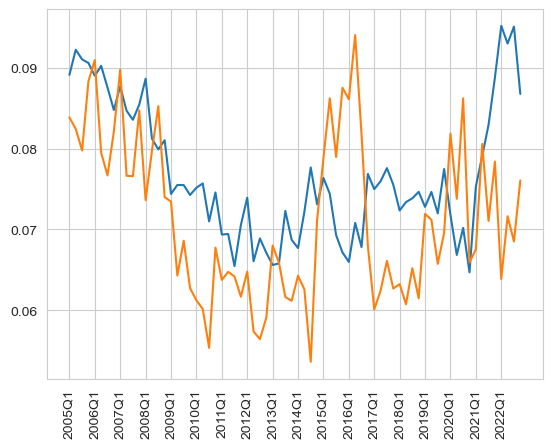

In [8]:
plt.plot(stocks_mo['A'], label='Women with children')
plt.plot(stocks_wo['A'], label='Women without children')
plt.xticks(stocks_wo['A'].index[::4],rotation=90)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


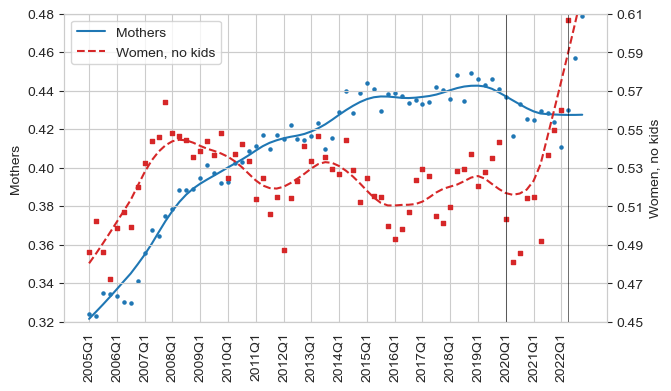

In [113]:
T = stocks_mo['P'].index.size
t0 = int(np.where(stocks_mo['P'].index=='2020Q1')[0])
colors= sn.color_palette()
fig, ax1 = plt.subplots(figsize=(7,4))

# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

lns1 = ax1.plot(lowess(stocks_mo['P'].values, np.arange(T),frac=1/5)[:,1], label='Mothers')
# plt.plot(np.arange(T-12,T),lowess(stocks_mo['P'].values[-12:], np.arange(T-12,T),frac=1)[:,1], c=colors[0])
ax1.scatter(np.arange(T),stocks_mo['P'].values, s=5)
ax1.set_xticks(np.arange(0,T,4),stocks_wo['P'].index[::4],rotation=90)
ax1.set_ylim(0.32,0.48)
ax1.set_ylabel('Mothers')


lns2 = ax2.plot(lowess(stocks_wo['P'].values, np.arange(T),frac=1/5)[:,1],c=colors[3], ls='--',label='Women, no kids')
# plt.plot(np.arange(T-12,T),lowess(stocks_wo['P'].values[-12:], np.arange(T-12,T),frac=1)[:,1], c=colors[1])
ax2.scatter(np.arange(T),stocks_wo['P'].values, s=5,marker='s',c=colors[3])
ax2.set_ylim(0.45,0.6)
ax2.set_ylabel('Women, no kids')
ax2.set_yticks(np.arange(0.45,0.62,0.02))

plt.axvline(t0,c='k',lw=0.4)
plt.axvline(T-3,c='k',lw=0.4)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.savefig('./descriptive_stats/stocks_P_mothers_3040.pdf',format='pdf',bbox_inches='tight')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


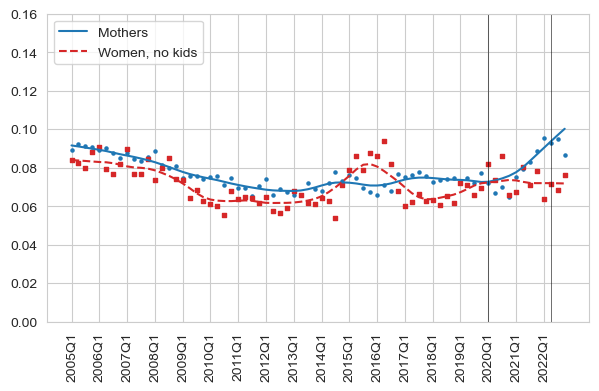

In [112]:
T = stocks_mo['A'].index.size
t0 = int(np.where(stocks_mo['A'].index=='2020Q1')[0])
colors= sn.color_palette()

plt.figure(figsize=(7,4))
plt.plot(lowess(stocks_mo['A'].values, np.arange(T),frac=1/6)[:,1], label='Mothers')
# plt.plot(np.arange(T-12,T),lowess(stocks_mo['A'].values[-12:], np.arange(T-12,T),frac=1)[:,1], c=colors[0])
plt.scatter(np.arange(T),stocks_mo['A'].values, s=5)
plt.plot(lowess(stocks_wo['A'].values, np.arange(T),frac=1/6)[:,1],c=colors[3], ls='--',label='Women, no kids')
# plt.plot(np.arange(T-12,T),lowess(stocks_wo['A'].values[-12:], np.arange(T-12,T),frac=1)[:,1], c=colors[1])
plt.scatter(np.arange(T),stocks_wo['A'].values, s=5,marker='s',c=colors[3])
plt.xticks(np.arange(0,T,4),stocks_wo['A'].index[::4],rotation=90)
plt.axvline(t0,c='k',lw=0.4)
plt.axvline(T-3,c='k',lw=0.4)
plt.ylim(0,0.16)
plt.legend()
plt.savefig('./descriptive_stats/stocks_A_mothers_3040.pdf',format='pdf',bbox_inches='tight')
plt.show()

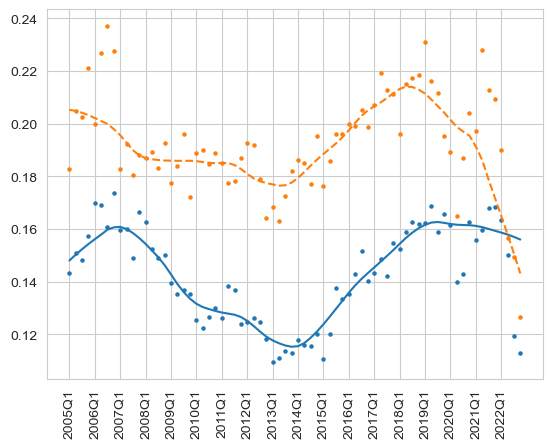

In [47]:
T = stocks_mo['T'].index.size
colors= sn.color_palette()
plt.plot(lowess(stocks_mo['T'].values, np.arange(T),frac=1/5)[:,1], label='Women with children')
# plt.plot(np.arange(T-12,T),lowess(stocks_mo['T'].values[-12:], np.arange(T-12,T),frac=1)[:,1], c=colors[0])
plt.scatter(np.arange(T),stocks_mo['T'].values, s=5)
plt.plot(lowess(stocks_wo['T'].values, np.arange(T),frac=1/5)[:,1], ls='--',label='Women with children')
# plt.plot(np.arange(T-12,T),lowess(stocks_wo['T'].values[-12:], np.arange(T-12,T),frac=1)[:,1], c=colors[1])
plt.scatter(np.arange(T),stocks_wo['T'].values, s=5)
plt.xticks(np.arange(0,T,4),stocks_wo['T'].index[::4],rotation=90)
plt.savefig('./descriptive_stats/stocks_A_mothers_3040.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Adding self-employed

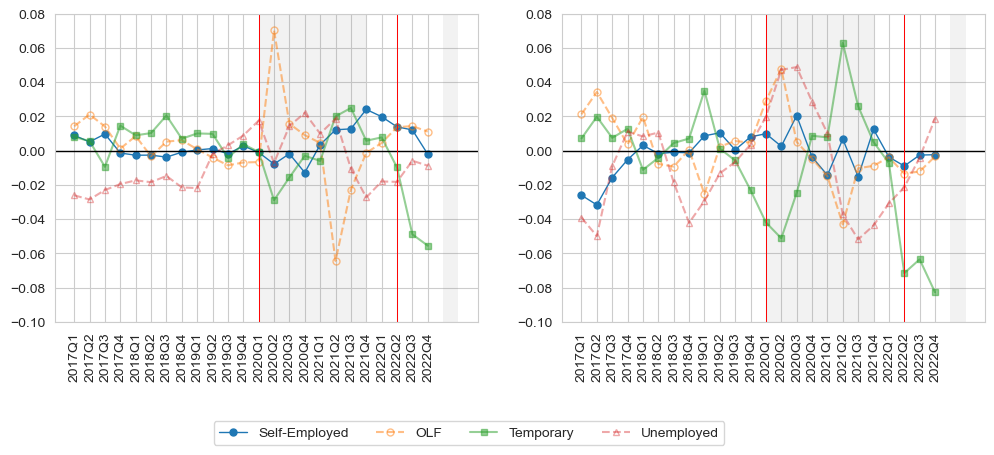

In [67]:
# t00 = 59
t0 = int(np.where(stocks_mo.index=='2017Q1')[0])
plt.figure(figsize=(12,4))
plt.subplot(121)
# plt.title('Incremento interanual del porcentaje de \n mujeres con hijos que son',fontsize=14,y=1.025)
plt.plot(stocks_mo.index[t0:],stocks_mo.loc['2016Q1':,"A"][4:].values-stocks_mo.loc['2016Q1':,"A"][:-4].values,
         marker='o',ms=5,lw=1,label='Self-Employed')
plt.plot(stocks_mo.index[t0:],stocks_mo.loc['2016Q1':,"I"][4:].values-stocks_mo.loc['2016Q1':,"I"][:-4].values,
         marker='o',ms=5,fillstyle='none',ls='--',label='OLF',alpha=0.5)
plt.plot(stocks_mo.index[t0:],stocks_mo.loc['2016Q1':,"T"][4:].values-stocks_mo.loc['2016Q1':,"T"][:-4].values,
         marker='s',ms=5,label='Temporary',alpha=0.5)
plt.plot(stocks_mo.index[t0:],stocks_mo.loc['2016Q1':,"U"][4:].values-stocks_mo.loc['2016Q1':,"U"][:-4].values,
         marker='^',ms=5,fillstyle='none',ls='--',label='Unemployed',alpha=0.4)
plt.xticks(stocks_mo.index[t0:],rotation=90)
plt.axhline(lw=1,c="k")
plt.ylim(-0.1,0.08)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=0.7)
plt.axvline('2022Q2',c='r',lw=0.7)
plt.legend(ncols=4,bbox_to_anchor=(1.6,-0.3))

plt.subplot(122)
# plt.title('Incremento interanual del porcentaje de \n mujeres con hijos que son',fontsize=14,y=1.025)
plt.plot(stocks_wo.index[t0:],stocks_wo.loc['2016Q1':,"A"][4:].values-stocks_wo.loc['2016Q1':,"A"][:-4].values,
         marker='o',ms=5,lw=1,label='Self-Employed')
plt.plot(stocks_wo.index[t0:],stocks_wo.loc['2016Q1':,"I"][4:].values-stocks_wo.loc['2016Q1':,"I"][:-4].values,
         marker='o',ms=5,fillstyle='none',ls='--',label='OLF',alpha=0.5)
plt.plot(stocks_wo.index[t0:],stocks_wo.loc['2016Q1':,"T"][4:].values-stocks_wo.loc['2016Q1':,"T"][:-4].values,
         marker='s',ms=5,label='Temporary',alpha=0.5)
plt.plot(stocks_wo.index[t0:],stocks_wo.loc['2016Q1':,"U"][4:].values-stocks_wo.loc['2016Q1':,"U"][:-4].values,
         marker='^',ms=5,fillstyle='none',ls='--',label='Unemployed',alpha=0.4)
plt.xticks(stocks_wo.index[t0:],rotation=90)
plt.axhline(lw=1,c="k")
plt.ylim(-0.1,0.08)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=0.7)
plt.axvline('2022Q2',c='r',lw=0.7)
# plt.legend()
plt.savefig('./descriptive_stats/stocks_change_mothers_3040.pdf',format='pdf',bbox_inches='tight')
plt.show()